In [114]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


#Import the excel file, the first sheet is the surface elevation, the second sheet is the formation and well info
filepath = r"C:\Users\thomas_ja\Desktop\CrossSectionTool\Copy of x_sec_data.xlsx"
df_elev = pd.read_excel(filepath, sheet_name='Elev')
df_cross = pd.read_excel(filepath, sheet_name='Xsecs')

#Here we split the well info sheet into formations and styles
df_formations = df_cross.set_index('W_NUM').loc[:, 'FORM_START' : 'STYLE_START'].drop(columns=['FORM_START', 'STYLE_START'])
df_style      = df_cross.set_index('W_NUM').loc[:, 'STYLE_START':].drop(columns=['STYLE_START'])


df_elev.head(10)

,OBJECTID *,Shape *,ORIG_LEN,ORIG_SEQ,XSec,LiDAR_Elev,Distance_Ft,ACTUAL_DISTANCE
0,1,Point,0.000000,1,B-B',28.67214,500,0
1,2,Point,0.001565,2,B-B',28.32927,1000,500
2,3,Point,0.003129,3,B-B',25.84028,1500,1000
3,4,Point,0.004694,4,B-B',26.83729,2000,1500
4,5,Point,0.006259,5,B-B',26.71501,2500,2000
5,6,Point,0.007823,6,B-B',26.43321,3000,2500
6,7,Point,0.009388,7,B-B',27.53563,3500,3000
7,8,Point,0.010953,8,B-B',27.27418,4000,3500
8,9,Point,0.012517,9,B-B',26.93416,4500,4000
9,10,Point,0.014082,10,B-B',23.85880,5000,4500


In [115]:
#This creates an array that can be plotted later. Surface elevation
elev = df_elev['LiDAR_Elev'].tolist()
distance = df_elev["ACTUAL_DISTANCE"].tolist()
elev_array = np.array([elev, distance])

#This extracts the distances for each well and the elevation of each well
locations = df_cross['DIST_FT'].tolist()
well_elev = np.array(df_cross['DEM_ELEV'].tolist())

In [116]:
df_formations.head()

,TQSU,HTRN,OCAL,AVPK,BTM
W_NUM,,,,,
16011,24,NaN,92,95.0,99
9999,30,NaN,90,100.0,110
1111,50,NaN,89,NaN,115
3475,63,NaN,89,NaN,126
14710,0,85.0,105,230.0,300


In [134]:
#This creates a list of all the formation names from the formation dataframe column headers
formations_list = df_formations.columns.tolist()

#This creates an array of the formation tops
all_formations = []
for formation in formations_list:
    temp_list = df_formations[formation].tolist()
    all_formations.append(temp_list)
formations_array = np.array(all_formations)

#Creates a mask that is used for the true formation depth calculation later
not_elev = formations_array != 0
#Creates an array of repeated well elevations that is used to calculate true formation depth
elev_stack = np.repeat([well_elev], formations_array.shape[0], axis=0)

#Calculates true formation depth by the difference of elevation and formation top only for values that arent equal to 0
formations_array[not_elev] = elev_stack[not_elev] - formations_array[not_elev]
#Calculates true formation depth by the sum of elevation and formation top for the values that are 0
formations_array[~not_elev] = elev_stack[~not_elev] + formations_array[~not_elev]

formations_array

array([[   4.6,   -6.2,  -45.2,  -57.9,   10.9],
       [   nan,    nan,    nan,    nan,  -74.1],
       [ -63.4,  -66.2,  -84.2,  -83.9,  -94.1],
       [ -66.4,  -76.2,    nan,    nan, -219.1],
       [ -70.4,  -86.2, -110.2, -120.9, -289.1]])

In [118]:
#Creates a list of style column headers
style_columns = df_style.columns.tolist()

#Creates an array of the style indicators that can be used for the polygon calculation decisions
all_styles = []
for style in style_columns:
    temp_list = df_style[style].tolist()
    all_styles.append(temp_list)
style_array = np.array(all_styles).astype('U')
style_array

array([['x', 'x', 'x', 'x', 'x'],
       ['n', 'n', 'n', 'x', 'f'],
       ['x', 'x', 'x', 'x', 'x'],
       ['x', 'p', 'n', 'n', 'p'],
       ['x', 'x', 'x', 'x', 'x']], dtype='<U1')

In [119]:
#Creates a copy of the formation array so that the original is preserved
big_array = np.copy(formations_array)

#Creates initial polygons for each formation, making sure that if the top of the formation is np.nan the bottom is too. 
#Also makes sure that if the formation below has np.nan as a value, it searches the next one down to make sure it has a number in the formation bottom
initial_polygon_list = []
for row in range(big_array.shape[0] - 1):
    first_row = np.copy(big_array[row])
    nan_template = np.isnan(first_row)

    second_row = np.copy(big_array[row + 1])
    second_row[nan_template] = np.nan
    nan_second = np.isnan(second_row)

    run = 2
    while not np.array_equal(nan_template, nan_second):
        values_needed = nan_template != nan_second
        second_row[values_needed] = big_array[row + run][values_needed]
        run += 1
        nan_second = np.isnan(second_row)
    #Append each initial polygon to a list where they can be accessed during the final polygon calculation
    initial_polygon_list.append(np.array([first_row, second_row]))

initial_polygon_list

[array([[  4.6,  -6.2, -45.2, -57.9,  10.9],
        [-63.4, -66.2, -84.2, -83.9, -74.1]]),
 array([[  nan,   nan,   nan,   nan, -74.1],
        [  nan,   nan,   nan,   nan, -94.1]]),
 array([[ -63.4,  -66.2,  -84.2,  -83.9,  -94.1],
        [ -66.4,  -76.2, -110.2, -120.9, -219.1]]),
 array([[ -66.4,  -76.2,    nan,    nan, -219.1],
        [ -70.4,  -86.2,    nan,    nan, -289.1]])]

In [128]:
########################################################################################################################################################
# The final polygon creation process
# Each polygon will be created in the same form 3-rows, 2Dimensions
# Row-1 is the formation top
# Row-2 is the formation bottom
# Row-3 is the corresponding x value for the depths in rows 1&2
# Polygons will no necessarily be of the same length, this is why they are added to a list and calulated seperately.
# That is also why the polygons all will contain their own x values within them.
########################################################################################################################################################
formation_polygons = []

for row in range(len(initial_polygon_list)):
    if np.any(style_array[row] == 'f'):
        print("Index of fade", np.where(style_array[row] == 'f')[0])
        
    elif np.any(style_array[row] == 'p'):
        print("Index of pinch", np.where(style_array[row] == 'p')[0])

    else: #These are the formations that do no pinch or fade
        #Checks if the next formation down pinches or fades
        if np.any(style_array[row+1] == 'f') or np.any(style_array[row+1] == 'p'):
            #If it does, the index of where it pinches or fades will be used to replace the bottom value of the top formation with the bottom value
            #of the lower formation, this is for ease of plotting later on.
            total_stack = initial_polygon_list[row].copy()
            bottom_replacements = (style_array[row+1] == 'f') | (style_array[row+1] == 'p')
            total_stack[1][bottom_replacements] =initial_polygon_list[row+1][1][bottom_replacements]
            #Lastly if creates the final polygon in the form of a 3-row 2D array and adds it to a list
            total_stack = np.vstack((total_stack, locations))
            formation_polygons.append(total_stack)
            

        else:
            total_stack = np.vstack(initial_polygon_list[row], locations)
            formation_polygons.append(total_stack)



formation_polygons

Index of fade [4]
Index of pinch [1 4]


[array([[ 4.6000e+00, -6.2000e+00, -4.5200e+01, -5.7900e+01,  1.0900e+01],
        [-6.3400e+01, -6.6200e+01, -8.4200e+01, -8.3900e+01, -9.4100e+01],
        [ 0.0000e+00,  4.5000e+03,  8.0000e+03,  1.1633e+04,  2.1870e+04]]),
 array([[  -63.4,   -66.2,   -84.2,   -83.9,   -94.1],
        [  -66.4,   -86.2,  -110.2,  -120.9,  -289.1],
        [    0. ,  4500. ,  8000. , 11633. , 21870. ]])]

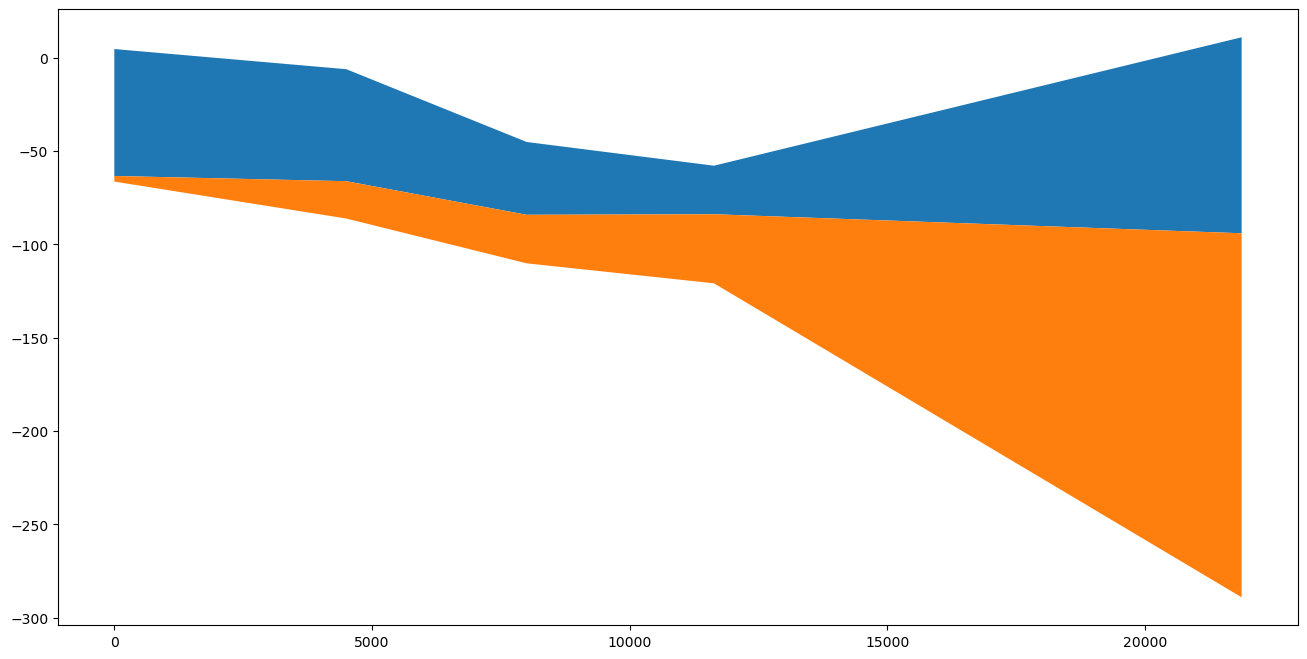

In [133]:
fig, ax = plt.subplots(figsize=(16, 8))


for formation in formation_polygons:
    ax.fill_between(formation[-1], formation[0], formation[1])


# ax.fill_between(locations, initial_polygon_list[0][0], initial_polygon_list[0][1])
# ax.fill_between(locations, initial_polygon_list[2][0], initial_polygon_list[2][1])
plt.show()